<center> <h1>Kilimanjaro Safaris Python Script</h1> </center>

<img src="KilimanjaroRhinos.jpg" width="60%">

The goal of this toy machine learning project is to predict wait times for Disney's Kilimanjaro Safaris, which is a safari attraction at Disney's Animal Kingdom in Lake Buena Vista, Florida.

We obtained a freely available wait time dataset from Disney and first cleaned it in R. We combine R and Python in this project to showcase are programming abilities and evidence that we are well-versed in a number of languages. The downloaded dataset has nearly three thousand daily observations that cover the period between January 2012 and December 2019.

The data cleaining procedures that we conducted in R had a number of steps. First, we combined the standby posted wait times and actual wait times to obtain the average wait time for the safari attraction for each day in the dataset. Second, we removed various codes that were present in the data but did not denote time (such as -999) to make sure we only work with actual wait times. Third, we converted various covariate data that we have avilable (such as the percentage of schools in session in Florida) into numeric variables. Finally, these covariate data was merged with the wait times.

We created two datasets, one with and one without covariates, to aid us at various stages of the analysis. Specifically, the simpler data was used to explore the autocorrelation present in the raw data whereas the more extensive dataset was used to produce the best possible predictions of wait times. 

The analysis begins below, each step is annoted for clarity. 

In [1]:
# importing the requisite packages; it is easiest to use this chunk to add more packages as needed
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from pandas import read_csv
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import read_csv
from matplotlib import pyplot
from matplotlib.lines import Line2D
from statsmodels.tsa.api import ARIMA
from pandas import DataFrame
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random


# this sets the style for plot backgrounds
sns.set_style("whitegrid")

In [2]:
# we begin by reading in the simple version of the dataset: chronologically ordered wait times without covariates
kilimanjaro = pd.read_csv("kilimanjaro_index.csv")


In [3]:
# taking a quick look at the data, wait times are averaged per day
kilimanjaro

,Unnamed: 0,wait_time
0,1,21.666667
1,100,21.250000
2,199,9.500000
3,226,31.222222
4,235,44.615385
...,...,...
2982,1528,76.090909
2983,1286,99.522727
2984,1294,72.791209
2985,1303,83.641304


Now that the data is loaded, we can first take a look at it. The key thing to notice is whether the mean of the data seems to change over time or whether it is more or less constant. This will matter later when we implement an ARIMA model because ARIMA works with stationary data.

Text(0, 0.5, 'Average Daily Wait Time (Minutes)')

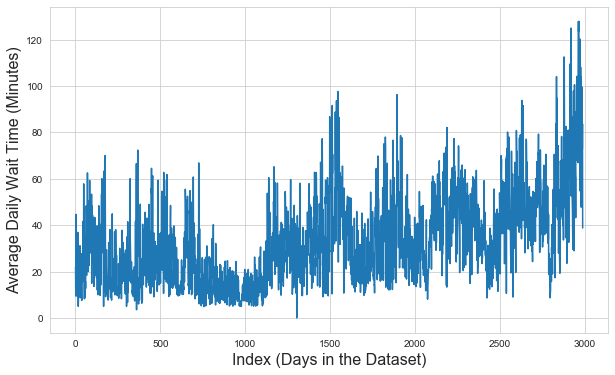

In [4]:
# this line sets the size of the plot we are about to produce
plt.figure(figsize=(10,6))

# this line plots the wait time series, using the index to identify the chronological order of the series
plt.plot(kilimanjaro.index, kilimanjaro.wait_time)

# adding labels
plt.xlabel("Index (Days in the Dataset)", fontsize=16)
plt.ylabel("Average Daily Wait Time (Minutes)", fontsize=16)

This dataset looks interesting because while it does look relatively stationary during the first few years, it seems to be trending towards higher wait times after about index number 2,000. What this means is that we will have to use a formal test that will tell us whether the data can be assumed to be stationary. The test we will use is the **Augmented Dickey-Fuller** test. It is very easy to implement and its null hypothesis is that the data is not stationary. Hence, if we see a p-value below our favorite (pre-determined) threshold, we will reject this null in favor of stationarity.

In [5]:
# checking stationarity with the Augmented Dickey-Fuller test
result = adfuller(kilimanjaro.wait_time)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.879789
p-value: 0.047749
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


The p-value is barely below the conventional 0.05 level which means that the data is likely stationary. To be sure, we do further work with the data to make sure it is palatable to ARIMA. The next chunk of code will explore how correlated wait times are, plotting a number of lags. 

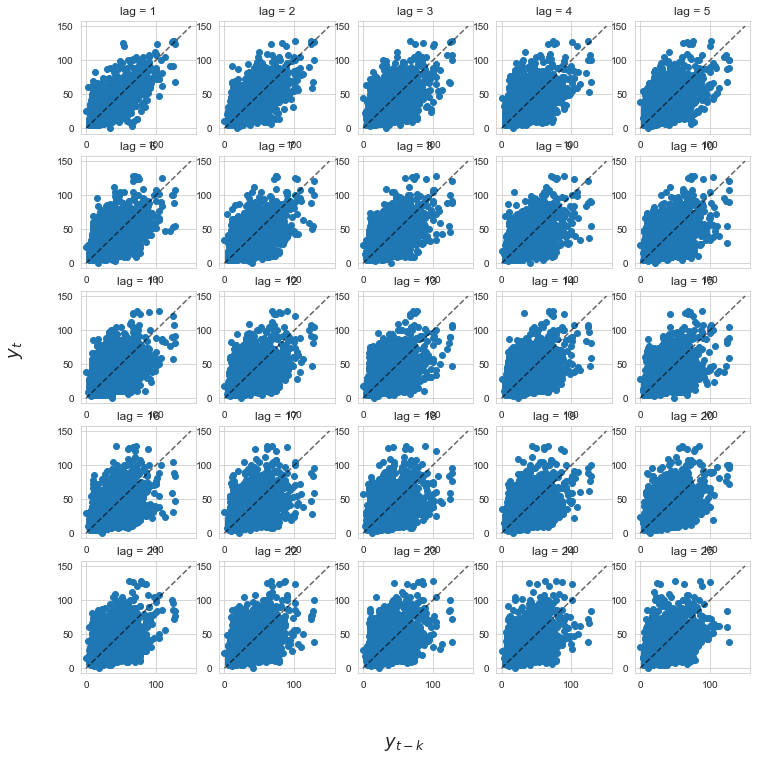

In [6]:
# here are some simple charts to explore how correlated wait times are 
def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

# a function to make plotting easier
def plot_lag(df,feature,lag,ax=None):
    df = make_lag_df(df,feature,lag).dropna()
    if ax:
        ax.scatter(df[feature+'_lag'],df[feature])

        ax.plot(np.linspace(0,150,25),
                np.linspace(0,150,25),
               'k--', alpha = .6)

        ax.set_title("lag = " + str(lag),fontsize=12)
    else:
        plt.scatter(df[feature+'_lag'],df[feature])

        plt.plot(np.linspace(0,150,25),
                np.linspace(0,150,25),
               'k--', alpha = .6)

        plt.show()
               
        
# this makes lag plots for lag = 1 through 25
fig,ax = plt.subplots(5,5,
                      figsize = (12,12))

for i in range(1,26):
    plot_lag(kilimanjaro,'wait_time',i,ax[(i-1)//5, (i-1)%5])

    
fig.text(0.5, 0.04, '$y_{t-k}$', ha='center',fontsize=18)
fig.text(0.04, 0.5, '$y_t$', va='center', rotation='vertical',fontsize=18)

plt.show()

The above plots are not very helpful but they do show that there is a lot of autocorrelation because observations cluster along the 45-degree line. We can estimate that the strongest autocorrelation happens up to about lag no. 10. To shed more light on autocorrelation, we next plot two diagnostic functions: **ACF** (autocorrelation function) and **PACF** (partial autocorrelation function). 

In [7]:
# these functions are used to quickly generate lags and autocorrelation
def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[0.7548494874034986, 0.6698784103259011, 0.6048239442625372, 0.5670397425841432, 0.5797328303409053, 0.6118809414250259, 0.6368924906762254, 0.5972487619059531, 0.5537714877987583, 0.5212058506802505, 0.5074285705024929, 0.5225231790681656, 0.5390222165667468, 0.5629172430558591, 0.5244961191162615, 0.49102397133874676, 0.4770074377426439, 0.46480490768971555, 0.48083689243518996, 0.5019805318192395, 0.5113099006887255, 0.48174289543784593, 0.45866008588969515, 0.4340427329054525]


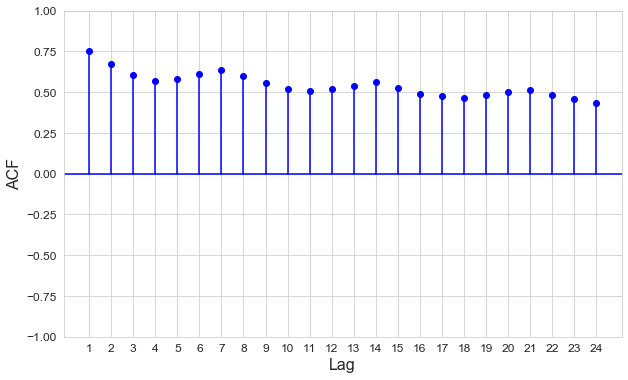

In [8]:
# here we explore autocorrelation in the data
# first we print autocorrelation coefficients for a few lags and than we print the ACF (autocorrelation function)

# for lag = 1 to 25
lags = np.arange(1,25,1)

print(lags)
print([get_autocorr(kilimanjaro,'wait_time',lag) for lag in lags])


# this is where code for the ACF begins
# making a figure
plt.figure(figsize=(10,6))

plt.ylim(-1,1)

# displaying 25 lags, change 25 if you need a different number of lags
plt.axhline(y=0, xmin=0, xmax=25, color = "blue")
plt.scatter(np.arange(1,25,1), 
           [get_autocorr(kilimanjaro,'wait_time',lag) for lag in np.arange(1,25,1)],
           c='b')

for i in np.arange(1,25,1):
    plt.plot(i*np.ones(2),[0,get_autocorr(kilimanjaro,'wait_time',i)],'b')

plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

plt.xticks(np.arange(1,25,1), fontsize=12)
plt.yticks(fontsize=12)

plt.show()


The above plot shows how autocorrelation changes with lags. There seems to be an uptick every seven days or so which could indicate that weekends (or Fridays) are experiencing longer wait times than the rest of the week. Let's explore the PACF.

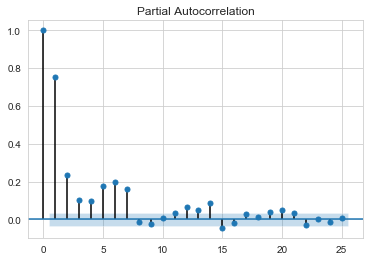

In [9]:
# PACF
plot_pacf(kilimanjaro.wait_time, lags=25)
pyplot.show()

The PACF yields a similar insight. There is massive autocorrelation of each observation with itself (the first spike), not a surprise there. After that, there is noticable autocorrelation for the first seven days (days six and seven in particular). Once we hit day eight, the autocorrelation trails off. This helps because now we know that the number of lags we should carefully consider is about 7.

One very simple way of reducting autocorrelation is to difference the data. We do that below.

In [10]:
# differencing the data and taking a look at the result; as expected, the first observation is missing because there is no 
# observation with which it could be differenced

kilimanjaro.diff().head()

,Unnamed: 0,wait_time
0,NaN,NaN
1,99.0,-0.416667
2,99.0,-11.750000
3,27.0,21.722222
4,9.0,13.393162


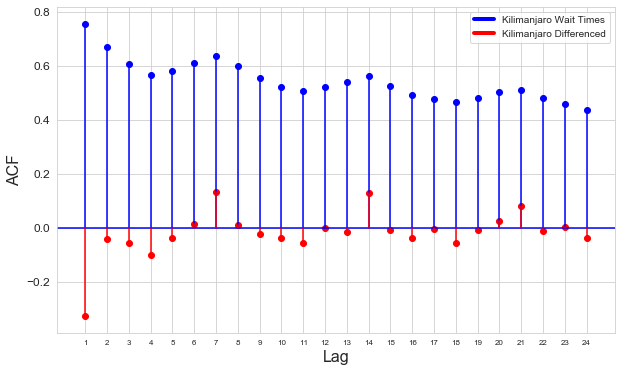

In [11]:
# the code below will display an ACF for the original data and an ACF for the differenced data

# plotting block
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4)]

# up to 25 lags
n=25

# this stores the autocorrelation for the data
kilimanjaro_autos = []

# getting the autocorrelation
for i in range(1,n,1):
    kilimanjaro_autos.append(get_autocorr(kilimanjaro,'wait_time',i))

# making a figure
plt.figure(figsize=(10,6))

# plotting a horizontal line
plt.axhline(y=0, xmin=0, xmax=n, color = "blue")

# plotting each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           kilimanjaro_autos,
           c='b')

# plotting vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,kilimanjaro_autos[i-1]],'b')

# adding labels
plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

# setting tick marks
plt.xticks(np.arange(1,n,1), fontsize=8)
plt.yticks(fontsize=12)


# placeholder for differenced data
kilimanjaro_diff_autos = []

# getting the autocorrelation for the differenced data
diff_data = kilimanjaro.diff().dropna().reset_index(drop=True)

for i in range(1,n,1):
    kilimanjaro_diff_autos.append(get_autocorr(diff_data,'wait_time',i))

# plotting each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           kilimanjaro_diff_autos,
           c='r')

# plotting vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,kilimanjaro_diff_autos[i-1]],'r')
    
plt.legend(custom_lines, ['Kilimanjaro Wait Times', 'Kilimanjaro Differenced'])

plt.show()


We can conclude that differencing the wait times helps somewhat but not too much. We see that the red lines still have an uptick every seven days, another reminder that weekends are special. The next step is to look at an actual ARIMA model and use our insight about the seven-day spikes. We will fit an ARIMA and evaluate the results.

In [12]:
# splitting the data between training and testing data, testing data will be 20 per cent of all observations
train_size = int(len(kilimanjaro) * 0.8)
kilimanjaro_train, kilimanjaro_test = kilimanjaro[0:train_size], kilimanjaro[train_size:]

# here is where we specify the parameters for our ARIMA (p, d, q)
# p is the number of lags included in the model 
# d is the degree of differencing, it should not be higher than 2
# q is the size of the moving average window

# we are running an ARIMA with p = 7 to account for weekends
arima = ARIMA(kilimanjaro_train.wait_time, order = (7,1,0)) # p, d, an q go here

fit = arima.fit()

# printing the summary from the estimated model, it has coefficients for each of the seven lags
print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.wait_time   No. Observations:                 2388
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -9118.253
Method:                       css-mle   S.D. of innovations             11.015
Date:                Fri, 29 May 2020   AIC                          18254.505
Time:                        18:32:01   BIC                          18306.509
Sample:                             1   HQIC                         18273.429
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0040      0.070      0.057      0.955      -0.134       0.142
ar.L1.D.wait_time    -0.5371      0.020    -26.248      0.000      -0.577      -0.497
ar.L2.D.wait_time    -0.

We see that the p-values for lags 1 through 6 are very small, which confirms our initial intuition that we are dealing with weekly cycles. Lag 7 has a surprisingly high p-value. 

Ultimately, our first goal is to clean the data of all autocorrelation and then look at the residuals. If we account for autocorrelation properly, we should see residuals with a mean of 0. 

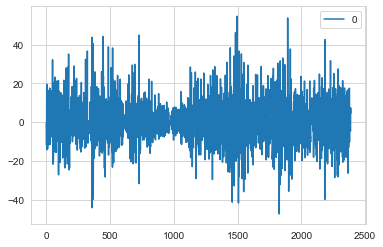

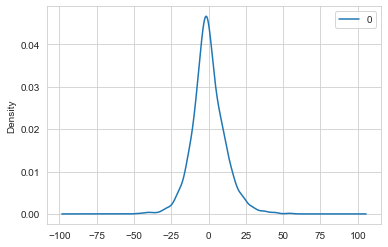

                 0
count  2388.000000
mean      0.003616
std      11.019443
min     -47.319395
25%      -6.236990
50%      -0.719374
75%       6.023917
max      54.618184


In [13]:
# plotting residual errors
residuals = DataFrame(fit.resid)

residuals.plot()

pyplot.show()

residuals.plot(kind='kde')

pyplot.show()

print(residuals.describe())

We see from the statistics above that the mean is Gaussian but it is not centered at 0. This could potentially be a problem because after removing autocorrelation, we want to see a mean of 0.

The solution could be to allow Python run through various combinations of the parameters (p, d, q) and pick the ones that lower mean squared error the most. The code below does just that by grid searching a palette of parameters. Note that this is a computationally demanding task and can take many hours to complete. 

In [14]:
# this function will evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # preparing training dataset, in this case 80 per cent of all data
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # making predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculating out-of-sample error
    error = mean_squared_error(test, predictions)
    return error


# evaluating combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    

# evaluating parameters
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")

# simplifying the dataset for the model evaluation function
series = read_csv('kilimanjaro_index.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# evaluating ARIMA models based on pre-specified range of parameters
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=842.037
ARIMA(0, 0, 1) MSE=473.117
ARIMA(0, 1, 0) MSE=276.541
ARIMA(0, 1, 1) MSE=228.110
ARIMA(1, 0, 0) MSE=264.044
ARIMA(1, 0, 1) MSE=229.272
ARIMA(1, 1, 0) MSE=246.264
ARIMA(1, 1, 1) MSE=215.670
ARIMA(2, 0, 0) MSE=242.460
ARIMA(2, 0, 1) MSE=216.587
ARIMA(2, 1, 0) MSE=237.137
ARIMA(2, 1, 1) MSE=214.918
ARIMA(3, 0, 0) MSE=236.860
ARIMA(3, 0, 1) MSE=216.064
ARIMA(3, 1, 0) MSE=233.925
ARIMA(3, 1, 1) MSE=216.302
ARIMA(4, 0, 0) MSE=233.924
ARIMA(4, 0, 1) MSE=217.434
ARIMA(4, 1, 0) MSE=227.492
ARIMA(4, 1, 1) MSE=216.204
ARIMA(5, 0, 0) MSE=227.316
ARIMA(5, 0, 1) MSE=216.678
ARIMA(5, 1, 0) MSE=222.170
ARIMA(5, 1, 1) MSE=216.238
ARIMA(6, 0, 0) MSE=221.899
ARIMA(6, 0, 1) MSE=216.776
ARIMA(6, 1, 0) MSE=214.303
ARIMA(6, 1, 1) MSE=214.473
ARIMA(7, 0, 0) MSE=214.623
ARIMA(7, 0, 1) MSE=214.802
ARIMA(7, 1, 0) MSE=214.483
ARIMA(7, 1, 1) MSE=210.700
Best ARIMA(7, 1, 1) MSE=210.700


We see that the best ARIMA has parameters 7, 1, 1. We know it is best because it has the lowest mean squared error. Based on this insight, we are going to re-fit an ARIMA model with these parameters and examine the results. 

In [15]:
# (7, 1, 1) ARIMA
arima = ARIMA(kilimanjaro_train.wait_time, order = (7,1,1)) # p, d, and q go here

fit = arima.fit()

# printing the summary from the estimated model, it has coefficients for each of the seven lags
print(fit.summary())


                             ARIMA Model Results                              
Dep. Variable:            D.wait_time   No. Observations:                 2388
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -9086.587
Method:                       css-mle   S.D. of innovations             10.868
Date:                Fri, 29 May 2020   AIC                          18193.174
Time:                        22:46:56   BIC                          18250.956
Sample:                             1   HQIC                         18214.201
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0072      0.016      0.441      0.659      -0.025       0.039
ar.L1.D.wait_time     0.4104      0.022     18.267      0.000       0.366       0.454
ar.L2.D.wait_time     0.

This does not look bad, p-values for many of the lags are low. Note that the AIC value is lower than that of the previously estimated model. This is another sign that we are doing better with the 7, 1, 1, model. Now that we have a model that seems to work relatively well for the training data set, we can use it on the test set and see how well it forecasts. 

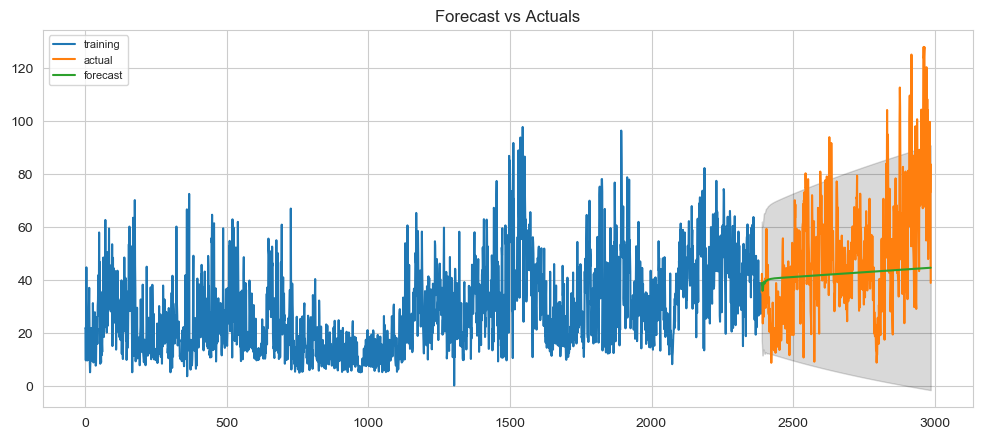

In [16]:
# producing forecast values based on our model
fc, se, conf = fit.forecast(598, alpha=0.05)  # 95% conf

# making a pandas series that will be used to plot the forecast
fc_series = pd.Series(fc, index=kilimanjaro_test.index)
lower_series = pd.Series(conf[:, 0], index=kilimanjaro_test.index) # this should link to the index values (time)
upper_series = pd.Series(conf[:, 1], index=kilimanjaro_test.index) # this should link to the index values (time)

# building the plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(kilimanjaro_train.wait_time, label='training') # this should link to the training values
plt.plot(kilimanjaro_test.wait_time, label='actual') # this should linke to the testing values
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, # this adds the confidence interval
                 color='k', alpha=.15)

# this adds the title and legend
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Clearly, we are not exceedingly happy with this forecast because the original series seems to trend towards higher values after roughly the first 2,500 observations. The next step is to load the dataset with covariates and run a **SARIMAX** model. This model will allow us run a very similar model like before; the difference is we will add covariates. 

In [17]:
# loading the dataset with covariates
kcov = pd.read_csv("kilimanjaro_covs.csv")

# splitting the data between training and testing data, testing data will be 20 per cent of all observations
train_size = int(len(kcov) * 0.8)
train, test = kcov[0:train_size], kcov[train_size:]


#setting up arrary of multiple exogenous variables for SARIMAX model
exog = np.empty([2330, 3]) # the first number has to be changed based on the size of the training set, second indicates
# the number of exogenous variables

# this builds an array of the exogenous variables we want to include
exog[:,0] = train.HOLIDAYPX
exog[:,1] = train.inSession_Florida
exog[:,2] = train.AKHOURS

# this removes NaNs (not a number) from the array, forecast does not run with NaNs
exog = np.nan_to_num(exog, nan=0.0)

# fitting the SARIMAX model and printing the results
model = SARIMAX(train.wait_time, exog=exog, order=(7, 1, 1), seasonal_order=(0, 0, 0, 52))
model_fit = model.fit(disp=False)
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              wait_time   No. Observations:                 2330
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -8776.724
Date:                Fri, 29 May 2020   AIC                          17577.448
Time:                        22:47:05   BIC                          17646.486
Sample:                             0   HQIC                         17602.602
                               - 2330                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0059      0.073     -0.080      0.936      -0.150       0.138
x2            -0.0581      0.010     -5.715      0.000      -0.078      -0.038
x3             3.0025      0.278     10.813      0.0

The first exogenous variable has a fairly high p-value and does not seem to contribute much. The other two covariates certainly seem to improve our fit and should probably be retained. The AIC can be used to compare to other models. So now that's exactly what we are going to do, compare multiple models and determine which one seems best.

Now that that we've run though one SARIMAX model and see the benefit of adding covariates, we are going to expand on that. Below is a for loop that runs though every possible combination of five of the specified covariates and stores measures of fit such as Mean Squared Error and AIC, as well p values for each coefficient as a measure of how important each individual covariates is to our overall predictions. Although five combinations is a somewhat arbitrary decision, it allows us to be parsimonious with the inclusion of covariates and works with our current levels of computing power (if we had easy access to a supercomputer, we'd expand upon this). The following variables have been included for possible selection based on our qualitative assessments: <br>
HOLIDAYPX: Proximity to Holiday (2-directional) (in days) <br>
HOLIDAYM: Day is a Holiday <br>
AKHOURS: Total Opening Hours for Animal Kingdom <br>
AKHOURSEMH: Total Opening Hours including Extra Magic Hours for Animal Kingdom <br>
inSession_sqrt_WDW: Percentage of Schools in Session Weighted by Square Root of Distance to WDW <br>
inSession_Florida: Percentage of Schools in Session Florida Only <br>
AKevent: Animal Kingdom Event

In [18]:
# the following chunk of code is way to make a list of all possible combinations of the variables 
# without having multiple of of the same variable in a list of 5
import itertools as it
covlist = ["HOLIDAYPX", "HOLIDAYM", "AKHOURS", "AKHOURSEMH", "inSession_sqrt_WDW", "inSession_Florida", 
           "AKevent"]
coms1 = list(it.combinations(covlist, 5))
#The below just create empty lists to store for loop information in
AICs = []
MSEs = []
pvalue0 = []
pvalue1 = []
pvalue2 = []
pvalue3 = []
pvalue4 = []

# Here begins the for loop wich is just running through the same code as our by hand model
for coms in coms1:
    a = coms[0]
    b = coms[1]
    c = coms[2]
    d = coms[3]
    e = coms[4]
    #setting up arrary of multiple exogenous variables for SARIMAX model
    exog = np.empty([2330, 5]) # the first number has to be changed based on the size of the training set, second indicates
    # the number of exogenous variables

    # this builds an array of the exogenous variables we want to include
    exog[:,0] = train[a]
    exog[:,1] = train[b]
    exog[:,2] = train[c]
    exog[:,3] = train[d]
    exog[:,4] = train[e]

    # this removes NaNs (not a number) from the array, forecast does not run with NaNs
    exog = np.nan_to_num(exog, nan=0.0)

    # fitting the SARIMAX model and printing the results
    model = SARIMAX(train.wait_time, exog=exog, order=(7, 1, 1), seasonal_order=(0, 0, 0, 52))
    model_fit = model.fit(disp=False)
    AICs.append(model_fit.aic)
    MSEs.append(model_fit.mse)
    pvalue0.append(model_fit.pvalues[0])
    pvalue1.append(model_fit.pvalues[1])
    pvalue2.append(model_fit.pvalues[2])
    pvalue3.append(model_fit.pvalues[3])
    pvalue4.append(model_fit.pvalues[4])
    # We were not able to extract coefficient as well, so sadly p values will have to do as a measure of 
    # if the covariates has a significant impact on wait times
#We will get plenty of MLE convergence errors from this, but everything if okay

In [19]:
# Now that we've extrated everything from that for loop we're interested in, let's make the data we are
# interested in into a data frame and make it easily viewable
coms1df = pd.DataFrame(coms1)
coms1df['AICs'] = AICs
coms1df['MSEs'] = MSEs
coms1df['p_value0'] = pvalue0
coms1df['p_value1'] = pvalue1
coms1df['p_value2'] = pvalue2
coms1df['p_value3'] = pvalue3
coms1df['p_value4'] = pvalue4
# and now here is the five combinations that produce the lowest AIC
coms1df.sort_values(by=['AICs']).head(10)

,0,1,2,3,4,AICs,MSEs,p_value0,p_value1,p_value2,p_value3,p_value4
1,HOLIDAYPX,HOLIDAYM,AKHOURS,AKHOURSEMH,inSession_Florida,17552.354788,108.526063,4.791863e-01,4.511950e-10,7.019563e-06,4.626610e-01,2.435571e-07
15,HOLIDAYM,AKHOURS,AKHOURSEMH,inSession_sqrt_WDW,inSession_Florida,17552.585297,108.527794,6.133882e-09,1.249517e-05,4.630627e-01,5.612173e-01,1.973638e-01
3,HOLIDAYPX,HOLIDAYM,AKHOURS,inSession_sqrt_WDW,inSession_Florida,17552.972094,108.545148,4.637246e-01,6.638545e-09,9.924849e-20,4.815652e-01,2.163776e-01
17,HOLIDAYM,AKHOURS,AKHOURSEMH,inSession_Florida,AKevent,17553.079458,108.555292,7.093819e-10,8.175663e-06,4.646640e-01,2.773216e-07,7.000860e-01
0,HOLIDAYPX,HOLIDAYM,AKHOURS,AKHOURSEMH,inSession_sqrt_WDW,17553.294801,108.561063,3.904048e-01,2.698555e-09,1.654426e-05,4.787243e-01,1.843777e-07
5,HOLIDAYPX,HOLIDAYM,AKHOURS,inSession_Florida,AKevent,17553.636642,108.586140,4.936599e-01,2.489109e-10,6.150730e-22,1.738716e-07,6.482471e-01
18,HOLIDAYM,AKHOURS,inSession_sqrt_WDW,inSession_Florida,AKevent,17553.783659,108.580545,4.786967e-09,1.054262e-19,5.310433e-01,2.030072e-01,7.072237e-01
16,HOLIDAYM,AKHOURS,AKHOURSEMH,inSession_sqrt_WDW,AKevent,17554.264697,108.601717,3.647862e-09,2.172623e-05,4.680293e-01,2.435330e-07,7.082543e-01
4,HOLIDAYPX,HOLIDAYM,AKHOURS,inSession_sqrt_WDW,AKevent,17554.488319,108.614452,4.124614e-01,2.347686e-09,2.862558e-19,1.426996e-07,6.537817e-01
6,HOLIDAYPX,HOLIDAYM,AKHOURSEMH,inSession_sqrt_WDW,inSession_Florida,17567.652674,109.171988,4.328797e-01,2.867243e-11,4.413482e-16,2.976567e-01,2.462287e-01


It looks like our model that produces the least amount of AIC and MSE includes the covariates HOLIDAYPX, HOLIDAYM, AKHOURS, AKHOURSEMH, and inSession_Florida. <br>
However, it is easy see from a qualitative standpoint that AKHOURS and AKHOURSEMH are going to be highly correlated as AKHOURS is the total amount of hours Animal Kingdom is open and AKHOURSEMH is the total amount of hours Animal Kingdom is open including extra magic hours (extra time that people staying at Disney World resorts can spend in the park). So, we're going to compare models that only include one or the other and see which one produces the least amount of AIC and MSE in our model.

The following code prints out the AIC and MSE for HOLIDAYPX, HOLIDAYM, AKHOURS, and inSession_Florida model.

In [20]:
#setting up arrary of multiple exogenous variables for SARIMAX model
exog = np.empty([2330, 4]) # the first number has to be changed based on the size of the training set, second indicates
# the number of exogenous variables

# this builds an array of the exogenous variables we want to include
exog[:,0] = train.HOLIDAYPX
exog[:,1] = train.HOLIDAYM
exog[:,2] = train.AKHOURS
exog[:,3] = train.inSession_Florida

# this removes NaNs (not a number) from the array, forecast does not run with NaNs
exog = np.nan_to_num(exog, nan=0.0)

# fitting the SARIMAX model and printing the results
model = SARIMAX(train.wait_time, exog=exog, order=(7, 1, 1), seasonal_order=(0, 0, 0, 52))
model_fit = model.fit(disp=False)
print(model_fit.aic, model_fit.mse)

17551.4334228186 108.57615387097732


The following code prints out the AIC and MSE for HOLIDAYPX, HOLIDAYM, AKHOURSEMH, and inSession_Florida model

In [21]:
#setting up arrary of multiple exogenous variables for SARIMAX model
exog = np.empty([2330, 4]) # the first number has to be changed based on the size of the training set, second indicates
# the number of exogenous variables

# this builds an array of the exogenous variables we want to include
exog[:,0] = train.HOLIDAYPX
exog[:,1] = train.HOLIDAYM
exog[:,2] = train.AKHOURSEMH
exog[:,3] = train.inSession_Florida

# this removes NaNs (not a number) from the array, forecast does not run with NaNs
exog = np.nan_to_num(exog, nan=0.0)

# fitting the SARIMAX model and printing the results
model = SARIMAX(train.wait_time, exog=exog, order=(7, 1, 1), seasonal_order=(0, 0, 0, 52))
model_fit = model.fit(disp=False)
print(model_fit.aic, model_fit.mse)

17566.613334042213 109.21555576210446


It looks like our HOLIDAYPX, HOLIDAYM, AKHOURS, and inSession_Florida model produces slightly smaller but noticeable differences in AIC and MSE. So we will use this as our final model.

Now that we have established our final model we are going to use, our next step is to use this model to forecast data from the test set. The following is our final model from our training set.

In [22]:
#setting up arrary of multiple exogenous variables for SARIMAX model
exogtrain = np.empty([2330, 4]) # the first number has to be changed based on the size of the training set, second indicates
# the number of exogenous variables

# this builds an array of the exogenous variables we want to include
exogtrain[:,0] = train.HOLIDAYPX
exogtrain[:,1] = train.HOLIDAYM
exogtrain[:,2] = train.AKHOURS
exogtrain[:,3] = train.inSession_Florida

# this removes NaNs (not a number) from the array, forecast does not run with NaNs
exogtrain = np.nan_to_num(exogtrain, nan=0.0)

# fitting the SARIMAX model and printing the results
model = SARIMAX(train.wait_time, exog=exogtrain, order=(7, 1, 1), seasonal_order=(0, 0, 0, 52))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              wait_time   No. Observations:                 2330
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -8762.717
Date:                Fri, 29 May 2020   AIC                          17551.433
Time:                        22:50:03   BIC                          17626.225
Sample:                             0   HQIC                         17578.684
                               - 2330                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0528      0.074      0.718      0.473      -0.091       0.197
x2             1.0459      0.166      6.306      0.000       0.721       1.371
x3             2.6998      0.281      9.612      0.0

And here we are making the comparable model from our test set.

In [23]:
# the chunk of code prepares a dataframe of the exogenous variables for the period we want to forecast
# the logic is that we know what day it will be and how many schools will be in session in Florida in the future
# hence, we use that predictable information with the insight of our SARIMAX model to forecast actual wait times

exogtest = np.empty([583, 4]) # the first number has to be changed based on the size of the training set
# the second numeral indicates the number of variables wrapped up in a dataframe
exogtest[:,0] = test.HOLIDAYPX
exogtest[:,1] = test.HOLIDAYM
exogtest[:,2] = test.AKHOURS
exogtest[:,3] = test.inSession_Florida

# this removes NaNs (not a number) from the array, forecast does not run with NaNs
exogtest = np.nan_to_num(exogtest, nan=0.0)

# this wraps up the exogenous variables in a dataframe for ease of use by forecast
df = pd.DataFrame(exogtest)

# this produces the desired forecast, note that I was not able to produce confidence intervals
fc = model_fit.forecast(583, alpha=0.05, exog=df)


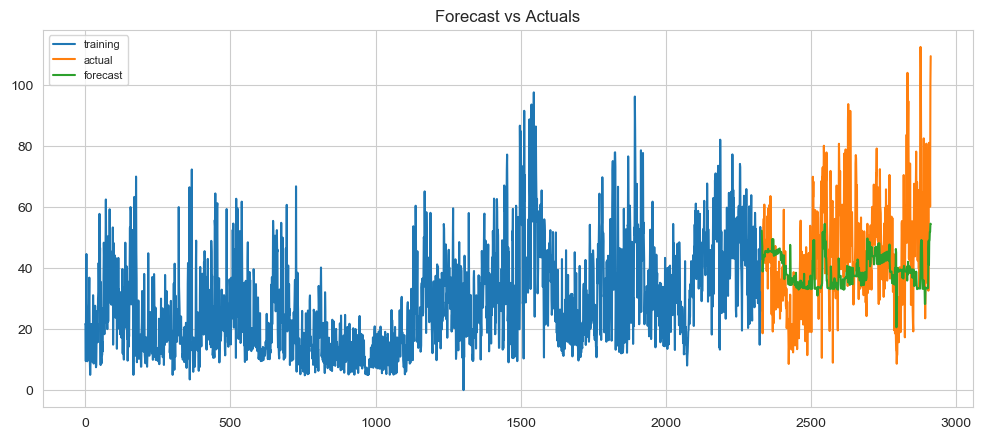

In [24]:
# making a pandas series that will be used to plot the forecast
fc_series = pd.Series(fc, index=test.index)

# building the plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.wait_time, label='training') # this should link to the training values
plt.plot(test.wait_time, label='actual') # this should link to the testing values
plt.plot(fc_series, label='forecast')

# this adds the title ane legend
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


Though the forecast is missing a confidence interval due to an intractable coding issue, we see that adding exogenous variables to the model truly improves the forecast. Whereas previously, we were forecasting a straight line that a five-year old would beat, our new forecast is much more respectable. The intuition behind this result is that the included predictors matter, on balance, a lot more than trying to discover some inner logic of the series with the AR and MA processes. Having said that, modeling these matters as well because it accounts for autocorrelation and makes our modeling approach more robust for situations when the exogenous variables will not be equally helpful.